## $2*m*[0.5 - \frac{1}{1 + e^{{ax}^b}}]$

In [1]:
import math
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import ElasticNet,Lasso,Ridge,LinearRegression,ElasticNetCV,LassoCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
input_data = pd.read_excel('./CellSage-based analyses (selected XCEL cells) (003) (version 1).xlsx')

In [3]:
input_data.iloc[:,13:20]

,"Cell 4 (9 cycles/day, 30 ⁰C)",Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,"Cell 5 (9 cycles/day, 30 ⁰C)"
0,"Lab Data, C/20 capacity loss",NaN,Single-SRE Analysis,NaN,NaN,NaN,"Lab Data, C/20 capacity loss"
1,Cycles,"Capacity loss, %","Time, Weeks",Cycles,"Capacity loss, %",NaN,Cycles
2,0,0,0,0,0,NaN,0
3,25,5.54677,0.0347222,2.1875,1.65181,NaN,25
4,50,9.73335,0.0713046,4.49219,2.53616,NaN,50
...,...,...,...,...,...,...,...
221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data1 = input_data.iloc[1:,15:18].dropna() # Remove null values
data1.columns = data1.loc[1] # Making the values in 1 row as column names
data1 = data1.loc[2:] # Selecting data from 2nd row
data1.reset_index(drop=True,inplace=True)
data1

1,"Time, Weeks",Cycles,"Capacity loss, %"
0,0,0,0
1,0.0347222,2.1875,1.65181
2,0.0713046,4.49219,2.53616
3,0.107887,6.79688,3.24085
4,0.144469,9.10156,3.84786
...,...,...,...
213,7.79018,490.781,19.8576
214,7.82676,493.086,19.8648
215,7.86334,495.391,19.872
216,7.89993,497.695,19.879


In [5]:
data1.columns

Index(['Time, Weeks', 'Cycles', 'Capacity loss, %'], dtype='object', name=1)

In [13]:
class SRE:
    def __init__(self,a,b,m,mc,mc_ml):
        self.a = a
        self.b = b
        self.m = m
        self.mc = mc
        self.mc_ml = mc_ml
        
    def expandgrid(self):
            product = list(itertools.product(list(np.ravel(self.a)),list(np.ravel(self.b)),list(np.ravel(self.m))))
            df = pd.DataFrame(product)
            arr_a = np.array(df[0])
            arr_b = np.array(df[1])
            arr_m = np.array(df[2])
            return arr_a,arr_b,arr_m
        
    def single_sre(self,a,b,m,mc):
        try:
            z = 1 + math.exp((a * mc)**b)
            f = 2* m * (0.5 - (1/z))
            return f
        except OverflowError:
            z = float('inf')
            return z
    
    def dataframe_of_inputs(self):
        sre_input_df = pd.DataFrame({'a':pd.Series(self.a),
                              'b':pd.Series(self.b),
                              'm':pd.Series(self.m)})
        
        
        array_input = np.meshgrid(self.a,self.b,self.m)
        return array_input,sre_input_df
        
    def multiple_SRE(self):
        fout = {}
        new_a,new_b,new_m = self.expandgrid()
        for i in range(len(self.mc)):
            z = np.exp(np.power(np.multiply(new_a,self.mc[i]),new_b))
            f = np.multiply(2,np.multiply(new_m,np.subtract(0.5,np.divide(1,np.add(1,z)))))
            fout.update({i:f})
        multi_sre_df = pd.DataFrame(fout).T
        multi_sre_df.index = [i for i in range(len(fout.keys()))]
        new_input_df = pd.DataFrame({'new_a':new_a,
                                    'new_b':new_b,
                                    'new_m':new_m})
        return multi_sre_df,fout,new_input_df

    def eNet(self,df,input_X,input_Y,cv=5,random_state=0):
        
        x_train,x_test,y_train,y_test = train_test_split(input_X,input_Y,test_size=0.05,random_state=random_state)
        train_index = list(x_train.index)
        test_index = list(x_test.index)
        Elastic_Net_CV_0 = ElasticNetCV(cv=cv, random_state=random_state,l1_ratio=0,alphas=np.arange(0,1,0.2)) # alpha = 0-1
        Elastic_Net_CV_0_5 = ElasticNetCV(cv=cv, random_state=random_state,l1_ratio=0.5)
        Elastic_Net_CV_1 = ElasticNetCV(cv=cv, random_state=random_state,l1_ratio=1)
        Elastic_Net_CV_0.fit(x_train, y_train)
        Elastic_Net_CV_0_5.fit(x_train, y_train)
        Elastic_Net_CV_1.fit(x_train, y_train)

        # add best_alpha
        #### add coefficients
        # add best_alpha
        
        # Predictions - alpha - 0
        predictions_train_0   = Elastic_Net_CV_0.predict(x_train) 
        predictions_test_0    = Elastic_Net_CV_0.predict(x_test)
        
        # Predictions - alpha -0.5
        predictions_train_0_5   = Elastic_Net_CV_0_5.predict(x_train) 
        predictions_test_0_5    = Elastic_Net_CV_0_5.predict(x_test)
        
        # Predictions - alpha -1
        predictions_train_1   = Elastic_Net_CV_1.predict(x_train) 
        predictions_test_1    = Elastic_Net_CV_1.predict(x_test)

        # RMSE - alpha - 0
#         RMSE_train_0    = np.round(np.sqrt(mean_squared_error(y_train, predictions_train_0)), 4 )
#         RMSE_test_0      = np.round(np.sqrt(mean_squared_error(y_test, predictions_test_0)), 4 )
        
#         # RMSE - alpha - 0.5
#         RMSE_train_0_5     = np.round(np.sqrt(mean_squared_error(y_train, predictions_train_0_5)), 4 )
#         RMSE_test_0_5      = np.round(np.sqrt(mean_squared_error(y_test, predictions_test_0_5)), 4 )
        
#         # RMSE -alpha - 1
#         RMSE_train_1     = np.round(np.sqrt(mean_squared_error(y_train, predictions_train_1)), 4 )
#         RMSE_test_1      = np.round(np.sqrt(mean_squared_error(y_test, predictions_test_1)), 4 )

        # R-Square - alpha - 0
        R_Sq_train_0     = np.round(Elastic_Net_CV_0.score(x_train, y_train), 4 )
        R_Sq_test_0      = np.round(Elastic_Net_CV_0.score(x_test, y_test), 4 )
        
        # R-Square - alpha - 0.5
        R_Sq_train_0_5     = np.round(Elastic_Net_CV_0_5.score(x_train, y_train), 4 )
        R_Sq_test_0_5      = np.round(Elastic_Net_CV_0_5.score(x_test, y_test), 4 )
        
        # R-Square - alpha - 1
        R_Sq_train_1     = np.round(Elastic_Net_CV_1.score(x_train, y_train), 4 )
        R_Sq_test_1      = np.round(Elastic_Net_CV_1.score(x_test, y_test), 4 )

#         # Adj. R-Square - alpha - 0
#         Adj_R_Sq_train_0  = np.round(1-(1-R_Sq_train_0) * (len(y_train)-1) / (len(y_train) - x_train.shape[1]-1), 4 )
#         Adj_R_Sq_test_0  = np.round(1-(1-R_Sq_test_0) * (len(y_test)-1) / (len(y_test) - x_test.shape[1]-1), 4 )
        
#         # Adj. R-Square - alpha - 0.5
#         Adj_R_Sq_train_0_5  = np.round(1-(1-R_Sq_train_0_5) * (len(y_train)-1) / (len(y_train) - x_train.shape[1]-1), 4 )
#         Adj_R_Sq_test_0_5  = np.round(1-(1-R_Sq_test_0_5) * (len(y_test)-1) / (len(y_test) - x_test.shape[1]-1), 4 )
        
#         # Adj. R-Square - alpha - 1
#         Adj_R_Sq_train_1  = np.round(1-(1-R_Sq_train_1) * (len(y_train)-1) / (len(y_train) - x_train.shape[1]-1), 4 )
#         Adj_R_Sq_test_1  = np.round(1-(1-R_Sq_test_1) * (len(y_test)-1) / (len(y_test) - x_test.shape[1]-1), 4 )

#         results_metrics_0 = pd.DataFrame({ 'Training Metrics': [RMSE_train_0, R_Sq_train_0, Adj_R_Sq_train_0],
#                                          'Testing Metrics': [RMSE_test_0,  R_Sq_test_0,  Adj_R_Sq_test_0 ]}, 
#                                         index = ['RMSE', 'R_Squared', 'Adj_R_Squared'])
#         results_metrics_0_5 = pd.DataFrame({ 'Training Metrics': [RMSE_train_0_5, R_Sq_train_0_5, Adj_R_Sq_train_0_5],
#                                          'Testing Metrics': [RMSE_test_0_5,  R_Sq_test_0_5,  Adj_R_Sq_test_0_5]}, 
#                                         index = ['RMSE', 'R_Squared', 'Adj_R_Squared'])
#         results_metrics_1 = pd.DataFrame({ 'Training Metrics': [RMSE_train_1, R_Sq_train_1, Adj_R_Sq_train_1],
#                                          'Testing Metrics': [RMSE_test_1,  R_Sq_test_1,  Adj_R_Sq_test_1]}, 
#                                         index = ['RMSE', 'R_Squared', 'Adj_R_Squared'])
        
        results_metrics_0 = pd.DataFrame({'Training Metrics': [R_Sq_train_0],'Testing Metrics': [R_Sq_test_0]}, 
                                         index = ['R_Squared'])
        results_metrics_0_5 = pd.DataFrame({ 'Training Metrics': [R_Sq_train_0_5],'Testing Metrics': [R_Sq_test_0_5]}, 
                                         index = ['R_Squared'])
        results_metrics_1 = pd.DataFrame({ 'Training Metrics': [R_Sq_train_1 ],'Testing Metrics': [R_Sq_test_1 ]}, 
                                         index = ['R_Squared'])
        
        df_train = df.loc[train_index]
        df_test = df.loc[test_index]
        
        ############# Time vs Train Predictions #############
        
#         plt.figure(figsize=(20,10))
#         plt.subplot(3,1,1)
#         sns.scatterplot(x=df_train['Time, Weeks'],y=predictions_train_0)
#         plt.title("Train Data - Time vs Predicted Capacity Loss for Alpha -0 ")
        
#         plt.subplot(3,1,2)
#         sns.scatterplot(x=df_train['Time, Weeks'],y=predictions_train_0_5)
#         plt.title("Train Data - Time vs Predicted Capacity Loss for Alpha -0.5 ")
        
#         plt.subplot(3,1,3)
#         sns.scatterplot(x=df_train['Time, Weeks'],y=predictions_train_1)
#         plt.title("Train Data - Time vs Predicted Capacity Loss for Alpha -1 ")
#         plt.tight_layout()
        
#         ############# Time vs Test Predictions #############
        
#         plt.figure(figsize=(20,10))
#         plt.subplot(3,1,1)
#         sns.scatterplot(x=df_test['Time, Weeks'],y=predictions_test_0)
#         plt.title("Test Data - Time vs Predicted Capacity Loss for Alpha -0 ")
        
#         plt.subplot(3,1,2)
#         sns.scatterplot(x=df_test['Time, Weeks'],y=predictions_test_0_5)
#         plt.title("Test Data - Time vs Predicted Capacity Loss for Alpha -0.5 ")
        
#         plt.subplot(3,1,3)
#         sns.scatterplot(x=df_test['Time, Weeks'],y=predictions_test_1)
#         plt.title("Test Data - Time vs Predicted Capacity Loss for Alpha -1 ")
#         plt.tight_layout()
        
#         ############# Cycles vs Train Predictions #############
        
#         plt.figure(figsize=(20,10))
#         plt.subplot(3,1,1)
#         sns.scatterplot(x=df_train['Cycles'],y=predictions_train_0)
#         plt.title("Train Data - Cycles vs Predicted Capacity Loss for Alpha -0 ")
        
#         plt.subplot(3,1,2)
#         sns.scatterplot(x=df_train['Cycles'],y=predictions_train_0_5)
#         plt.title("Train Data - Cycles vs Predicted Capacity Loss for Alpha -0.5 ")
        
#         plt.subplot(3,1,3)
#         sns.scatterplot(x=df_train['Cycles'],y=predictions_train_1)
#         plt.title("Train Data - Cycles vs Predicted Capacity Loss for Alpha -1 ")
#         plt.tight_layout()

        
#         ############# Cycles vs Test Predictions #############
        
#         plt.figure(figsize=(20,10))
#         plt.subplot(3,1,1)
#         sns.scatterplot(x=df_test['Cycles'],y=predictions_test_0)
#         plt.title("Test Data - Cycles vs Predicted Capacity Loss for Alpha -0 ")
        
#         plt.subplot(3,1,2)
#         sns.scatterplot(x=df_test['Cycles'],y=predictions_test_0_5)
#         plt.title("Test Data - Cycles vs Predicted Capacity Loss for Alpha -0.5 ")
        
#         plt.subplot(3,1,2)
#         sns.scatterplot(x=df_test['Cycles'],y=predictions_test_1)
#         plt.title("Test Data - Cycles vs Predicted Capacity Loss for Alpha -1 ")
#         plt.tight_layout()
#         plt.show()
        
        return results_metrics_0,results_metrics_0_5,results_metrics_1

In [14]:
if __name__ == '__main__':
    sre = SRE(a = np.linspace(0.0225-0.0045 ,0.0225+0.0045,10), #np.linspace(0.0001, 0.1,10), #0.0225 as mid point
              b = np.linspace(0.5,1,5),
              m = np.linspace(0.1,0.3,5),
              mc = list(data1['Cycles']),
              mc_ml = list(data1['Capacity loss, %']))
    exp = sre.expandgrid()
    multiple_sre_output,fout,new_inputdf = sre.multiple_SRE()
    array_input,df_input = sre.dataframe_of_inputs()
#     single_sre_output = []
#     for i in range(0,501):
#         single_sre_output.append(sre.single_sre(a=1.0,b=1.0,m=1.0,mc=i))

In [15]:
multiple_sre_output

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.009889,0.014834,0.019778,0.024723,0.029667,0.006612,0.009918,0.013224,0.016531,0.019837,...,0.004204,0.006305,0.008407,0.010509,0.012611,0.002952,0.004428,0.005905,0.007381,0.008857
2,0.014123,0.021184,0.028246,0.035307,0.042369,0.010345,0.015518,0.020691,0.025863,0.031036,...,0.007878,0.011817,0.015756,0.019695,0.023634,0.006057,0.009086,0.012114,0.015143,0.018171
3,0.017313,0.025969,0.034625,0.043282,0.051938,0.013369,0.020054,0.026738,0.033423,0.040107,...,0.011293,0.016940,0.022587,0.028234,0.033880,0.009150,0.013725,0.018300,0.022875,0.027450
4,0.019966,0.029949,0.039932,0.049915,0.059898,0.016003,0.024005,0.032007,0.040009,0.048010,...,0.014540,0.021809,0.029079,0.036349,0.043619,0.012226,0.018338,0.024451,0.030564,0.036677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.090261,0.135391,0.180521,0.225651,0.270782,0.096042,0.144063,0.192084,0.240105,0.288126,...,0.099986,0.149980,0.199973,0.249966,0.299959,0.100000,0.149999,0.199999,0.249999,0.299999
214,0.090325,0.135487,0.180650,0.225812,0.270975,0.096086,0.144129,0.192172,0.240215,0.288258,...,0.099987,0.149980,0.199974,0.249967,0.299961,0.100000,0.150000,0.199999,0.249999,0.299999
215,0.090389,0.135583,0.180778,0.225972,0.271166,0.096130,0.144194,0.192259,0.240324,0.288389,...,0.099987,0.149981,0.199975,0.249968,0.299962,0.100000,0.150000,0.199999,0.249999,0.299999
216,0.090452,0.135678,0.180904,0.226130,0.271356,0.096173,0.144259,0.192345,0.240432,0.288518,...,0.099988,0.149982,0.199976,0.249970,0.299964,0.100000,0.150000,0.199999,0.249999,0.299999


In [16]:
new_inputdf

,new_a,new_b,new_m
0,0.018,0.5,0.10
1,0.018,0.5,0.15
2,0.018,0.5,0.20
3,0.018,0.5,0.25
4,0.018,0.5,0.30
...,...,...,...
245,0.027,1.0,0.10
246,0.027,1.0,0.15
247,0.027,1.0,0.20
248,0.027,1.0,0.25


In [17]:
# Appending all RSquares in one list
All_rsquares_0 = []
All_rsquares_0_5 = []
All_rsquares_1 = []
for i in multiple_sre_output.iloc[:,0:5]:
    print("Column Number {} of Multiple SRE Output".format(i))
    print("="*125)
    metrics_0,metrics_0_5,metrics_1 = sre.eNet(input_X=multiple_sre_output.iloc[:,i:i+1],input_Y=data1['Capacity loss, %'],df=data1)
    r_sq_0 = metrics_0[['Testing Metrics']].loc['R_Squared'].values[0]
    r_sq_0_5 = metrics_0_5[['Testing Metrics']].loc['R_Squared'].values[0]
    r_sq_1 = metrics_1[['Testing Metrics']].loc['R_Squared'].values[0]
    All_rsquares_0.append(r_sq_0)
    All_rsquares_0_5.append(r_sq_0_5)
    All_rsquares_1.append(r_sq_1)
    print("="*125)

# Creating Dataframe with R Sqaures
top_3_rsqs_0 = pd.DataFrame(sorted(All_rsquares_0,reverse=True),columns=['R_Squared'],index=range(len(All_rsquares_0))).head(3)
top_3_rsqs_0_5 = pd.DataFrame(sorted(All_rsquares_0_5,reverse=True),columns=['R_Squared'],index=range(len(All_rsquares_0_5))).head(3)
top_3_rsqs_1 = pd.DataFrame(sorted(All_rsquares_1,reverse=True),columns=['R_Squared'],index=range(len(All_rsquares_1))).head(3)

new_inputdf['R-Squared-0'] = All_rsquares_0
new_inputdf['R-Squared-0_5'] = All_rsquares_0_5
new_inputdf['R-Squared-1'] = All_rsquares_1

new_inputdf_0 = pd.DataFrame()
new_inputdf_0['new_a'] = new_inputdf['new_a']
new_inputdf_0['new_b'] = new_inputdf['new_b']
new_inputdf_0['new_m'] = new_inputdf['new_m']
new_inputdf_0['R-Squared-0'] = All_rsquares_0

new_inputdf_0_5 = pd.DataFrame()
new_inputdf_0_5['new_a'] = new_inputdf['new_a']
new_inputdf_0_5['new_b'] = new_inputdf['new_b']
new_inputdf_0_5['new_m'] = new_inputdf['new_m']
new_inputdf_0_5['R-Squared-0_5'] = All_rsquares_0_5

new_inputdf_1 = pd.DataFrame()
new_inputdf_1['new_a'] = new_inputdf['new_a']
new_inputdf_1['new_b'] = new_inputdf['new_b']
new_inputdf_1['new_m'] = new_inputdf['new_m']
new_inputdf_1['R-Squared-1'] = All_rsquares_1

Column Number 0 of Multiple SRE Output
Column Number 1 of Multiple SRE Output
Column Number 2 of Multiple SRE Output
Column Number 3 of Multiple SRE Output
Column Number 4 of Multiple SRE Output


ValueError: Length of values (5) does not match length of index (250)

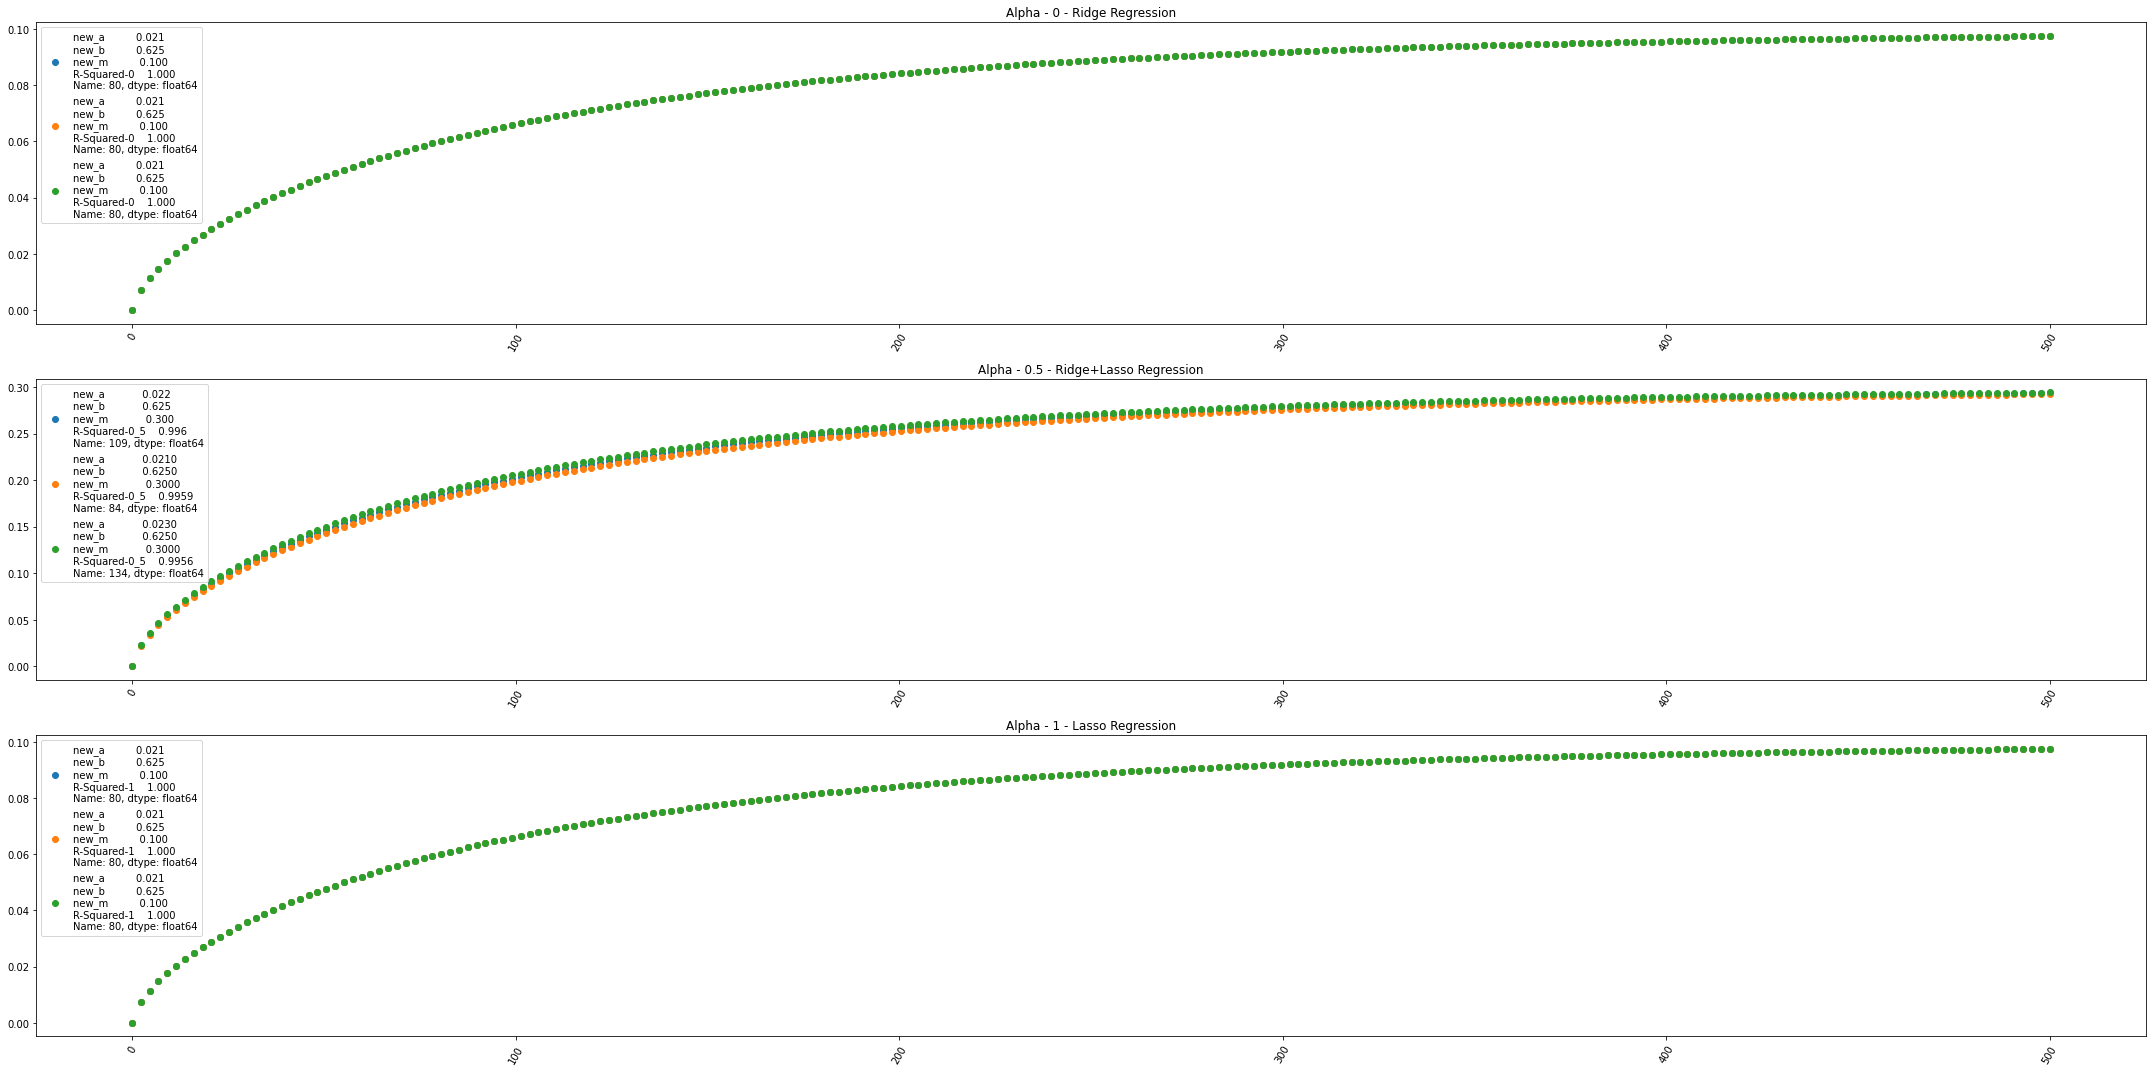

In [109]:
plt.figure(figsize=(30,15))

############ alpha - 0 #############
plt.subplot(3,1,1)
plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_0.index(top_3_rsqs_0.loc[0].values[0])])

plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_0.index(top_3_rsqs_0.loc[1].values[0])])

plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_0.index(top_3_rsqs_0.loc[2].values[0])])

plt.xticks(rotation=60)
plt.legend([str(new_inputdf_0.loc[All_rsquares_0.index(top_3_rsqs_0.loc[0].values[0])]),
            str(new_inputdf_0.loc[All_rsquares_0.index(top_3_rsqs_0.loc[1].values[0])]),
            str(new_inputdf_0.loc[All_rsquares_0.index(top_3_rsqs_0.loc[2].values[0])])])
plt.title("Alpha - 0 - Ridge Regression")

############## - alpha - 0.5 #############

plt.subplot(3,1,2)
plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_0_5.index(top_3_rsqs_0_5.loc[0].values[0])])

plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_0_5.index(top_3_rsqs_0_5.loc[1].values[0])])

plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_0_5.index(top_3_rsqs_0_5.loc[2].values[0])])

plt.xticks(rotation=60)
plt.legend([str(new_inputdf_0_5.loc[All_rsquares_0_5.index(top_3_rsqs_0_5.loc[0].values[0])]),
            str(new_inputdf_0_5.loc[All_rsquares_0_5.index(top_3_rsqs_0_5.loc[1].values[0])]),
            str(new_inputdf_0_5.loc[All_rsquares_0_5.index(top_3_rsqs_0_5.loc[2].values[0])])])
plt.title("Alpha - 0.5 - Ridge+Lasso Regression")

############# - aplpha - 1 ###############

plt.subplot(3,1,3)
plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_1.index(top_3_rsqs_1.loc[0].values[0])])

plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_1.index(top_3_rsqs_1.loc[1].values[0])])

plt.scatter(x=data1['Cycles'],
            y=multiple_sre_output.iloc[:,All_rsquares_1.index(top_3_rsqs_1.loc[2].values[0])])

plt.xticks(rotation=60)
plt.legend([str(new_inputdf_1.loc[All_rsquares_1.index(top_3_rsqs_1.loc[0].values[0])]),
            str(new_inputdf_1.loc[All_rsquares_1.index(top_3_rsqs_1.loc[1].values[0])]),
            str(new_inputdf_1.loc[All_rsquares_1.index(top_3_rsqs_1.loc[2].values[0])])])

plt.title("Alpha - 1 - Lasso Regression")
plt.tight_layout()
plt.show()

In [122]:
top_3_rsqs_0_5

,R_Squared
0,0.9960
1,0.9959
2,0.9956


In [123]:
bp1 = new_inputdf_0.loc[All_rsquares_0.index(top_3_rsqs_0.loc[0].values[0]):All_rsquares_0.index(top_3_rsqs_0.loc[0].values[0])]
bp2 = new_inputdf_0_5.loc[All_rsquares_0_5.index(top_3_rsqs_0_5.loc[0].values[0]):All_rsquares_0_5.index(top_3_rsqs_0_5.loc[0].values[0])]
bp3 = new_inputdf_1.loc[All_rsquares_1.index(top_3_rsqs_1.loc[0].values[0]):All_rsquares_1.index(top_3_rsqs_1.loc[0].values[0])]

# Create DF for all three 0,0.5,1 - Top 3 a,b,m from each df along with RSquared

In [124]:
pd.concat([bp1,bp2,bp3])

,new_a,new_b,new_m,R-Squared-0,R-Squared-0_5,R-Squared-1
80,0.021,0.625,0.1,1.0,NaN,NaN
109,0.022,0.625,0.3,NaN,0.996,NaN
80,0.021,0.625,0.1,NaN,NaN,1.0


- Time vs Predicted Capacity Loss
- Cycles vs Predicted Capacity Loss
- 0,0.5,1 alpha - get rSquared
- Create DF for all three 0,0.5,1 - Top 3 a,b,m from each df along with RSquared
- Create a big dataframe with all 0,0.5,1 a,b,m,rsquared

# 0,0.5,1 alpha - get rSquared

In [116]:
R_Squares_df = pd.DataFrame({'R_Squares-0':All_rsquares_0,
              'R_Squares-0.5':All_rsquares_0_5,
              'R_Squares-1':All_rsquares_1})
R_Squares_df

,R_Squares-0,R_Squares-0.5,R_Squares-1
0,0.9894,0.9507,0.9893
1,0.9894,0.9686,0.9893
2,0.9894,0.9761,0.9893
3,0.9894,0.9800,0.9893
4,0.9894,0.9823,0.9893
...,...,...,...
245,0.8764,0.8854,0.8775
246,0.8764,0.8884,0.8775
247,0.8764,0.8880,0.8775
248,0.8764,0.8871,0.8775


# Create a big dataframe with all 0,0.5,1 a,b,m,rsquared

In [125]:
new_inputdf

,new_a,new_b,new_m,R-Squared-0,R-Squared-0_5,R-Squared-1
0,0.018,0.5,0.10,0.9894,0.9507,0.9893
1,0.018,0.5,0.15,0.9894,0.9686,0.9893
2,0.018,0.5,0.20,0.9894,0.9761,0.9893
3,0.018,0.5,0.25,0.9894,0.9800,0.9893
4,0.018,0.5,0.30,0.9894,0.9823,0.9893
...,...,...,...,...,...,...
245,0.027,1.0,0.10,0.8764,0.8854,0.8775
246,0.027,1.0,0.15,0.8764,0.8884,0.8775
247,0.027,1.0,0.20,0.8764,0.8880,0.8775
248,0.027,1.0,0.25,0.8764,0.8871,0.8775
